<a href="https://colab.research.google.com/github/Jamnic98/blue-cheese-classifier/blob/main/blue_cheese_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import modules
import os
import numpy as np
import shutil.copy
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from contextlib import redirect_stdout

# mount the google drive and change directory
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [ ]:
root_dir = '/content/drive/MyDrive/'
class_names = ['blueCheese', 'notBlueCheese']
all_cheese_image_dirs = {class_names[0]: [], class_names[1]: []}

# create train, test and validation folders for each class of cheese
for class_name in class_names:
  # create train folder
  os.makedirs(root_dir +'data/train/' + class_name)
  # create test folder
  os.makedirs(root_dir +'data/test/' + class_name)
  # create validation folder
  os.makedirs(root_dir +'data/val/' + class_name)

  # compile a list of URIs for each type of cheese
  cheeses = os.listdir(root_dir + class_name)
  for cheese_name in cheeses:
    cheese_dir = root_dir + class_name + '/' + cheese_name
    all_cheese_image_dirs[class_name].extend(
      [cheese_dir + '/'+ name for name in os.listdir(cheese_dir)]
      )  

In [ ]:
val_ratio = 0.05
test_ratio = 0.15

for class_name in class_names:
  cheese_image_dirs = all_cheese_image_dirs[class_name]

  # shuffle image URIs
  np.random.shuffle(cheese_image_dirs)

  train_FileNames, val_FileNames, test_FileNames = np.split(
    np.array(cheese_image_dirs),
    [int(len(cheese_image_dirs)* (1 - (val_ratio + test_ratio))), 
    int(len(cheese_image_dirs)* (1 - test_ratio))]
  )

  # print('In folder :', class_name)
  # print('Total images: ', len(cheese_image_dirs))
  # print('Training: ', len(train_FileNames))
  # print('Validation: ', len(val_FileNames))
  # print('Testing: ', len(test_FileNames))
  # print('\n')

  # # Copy-pasting images
  # for train_FileName in train_FileNames.tolist():
  #   shutil.copy(train_FileName, root_dir +'data/train/' + class_name)

  # for val_FileName in val_FileNames.tolist():
  #   shutil.copy(val_FileName, root_dir +'data/val/' + class_name)

  # for test_FileName in test_FileNames.tolist():
  #   shutil.copy(test_FileName, root_dir +'data/test/' + class_name)

In folder : blueCheese
Total images:  1896
Training:  1611
Validation:  95
Testing:  190


In folder : notBlueCheese
Total images:  1848
Training:  1570
Validation:  93
Testing:  185




In [ ]:
augmented_images_dir = root_dir + 'augmented_images/'
if not os.path.isdir(augmented_images_dir):
  os.mkdir(augmented_images_dir)

# augment the data that we have
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# prepare training data
augmented_train_images_dir = augmented_images_dir + 'train'
if not os.path.isdir(augmented_train_images_dir):
  os.mkdir(augmented_train_images_dir)
training_data = train_datagen.flow_from_directory('data/train',
                                                  # save_to_dir=augmented_train_images_dir,
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode='categorical'
                                                  )

# prepare test data
augmented_test_images_dir = augmented_images_dir + 'test'
if not os.path.isdir(augmented_test_images_dir):
  os.mkdir(augmented_test_images_dir)
test_data = test_datagen.flow_from_directory('data/test',
                                              # save_to_dir=augmented_test_images_dir,
                                              target_size = (256, 256),
                                              batch_size = 32,
                                              class_mode = 'categorical'
                                              )

# prepare validation data
augmented_val_images_dir = augmented_images_dir + 'val'
if not os.path.isdir(augmented_val_images_dir):
  os.mkdir(augmented_val_images_dir)
validation_data = test_datagen.flow_from_directory('data/val',
                                                    # save_to_dir=augmented_val_images_dir,
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical'
                                                    )

Found 2994 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Found 562 images belonging to 2 classes.


## Build the model

In [ ]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# make 32 feature detectors with a size of 3x3
# choose the input-image's format to be 256x256 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation="relu"))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="softmax", units=2))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Train the model

In [ ]:
history = classifier.fit(training_data,
               #steps_per_epoch = (10),
               epochs=100,
               validation_data=validation_data,
               validation_steps=10,
               callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
 4/94 [>.............................] - ETA: 1:09 - loss: 1.3678 - accuracy: 0.4004

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


93/94 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.5658

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19 bytes but only got 18. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag)


94/94 [==============================] - 77s 802ms/step - loss: 0.7779 - accuracy: 0.5673 - val_loss: 0.6192 - val_accuracy: 0.6406
Epoch 2/100
94/94 [==============================] - 75s 796ms/step - loss: 0.5996 - accuracy: 0.6747 - val_loss: 0.5963 - val_accuracy: 0.7219
Epoch 3/100
94/94 [==============================] - 74s 791ms/step - loss: 0.5751 - accuracy: 0.7143 - val_loss: 0.5553 - val_accuracy: 0.7625
Epoch 4/100
94/94 [==============================] - 74s 793ms/step - loss: 0.5810 - accuracy: 0.6884 - val_loss: 0.5184 - val_accuracy: 0.7437
Epoch 5/100
94/94 [==============================] - 75s 794ms/step - loss: 0.5541 - accuracy: 0.7115 - val_loss: 0.5857 - val_accuracy: 0.6562
Epoch 6/100
94/94 [==============================] - 75s 788ms/step - loss: 0.5563 - accuracy: 0.7153 - val_loss: 0.5162 - val_accuracy: 0.7250
Epoch 7/100
94/94 [==============================] - 74s 790ms/step - loss: 0.5174 - accuracy: 0.7288 - val_loss: 0.5097 - val_accuracy: 0.7281
Epoc

In [ ]:
generator= train_datagen.flow_from_directory("data/train", batch_size=32)
label_map = (generator.class_indices)
label_map

Found 2994 images belonging to 2 classes.


{'blueCheese': 0, 'notBlueCheese': 1}

In [ ]:
# from tensorflow import keras
# classifier = keras.models.load_model(root_dir + 'my_model')

In [ ]:
## make predictions

# resize image
test_image = load_img('data/test/notBlueCheese/red_leicester101.jpg', target_size = (256, 256))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print('Predicted class: ', int(result[0][0]))
# print(result)

predictions = classifier.predict(test_data)
# print(predictions)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
confusion_matrix

Predicted class:  0


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[41, 54],
       [49, 44]])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 2s - loss: 0.2158 - accuracy: 0.9202
Accuracy:  0.9202127456665039


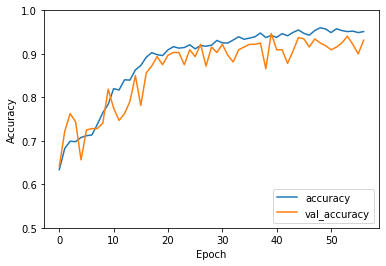

In [ ]:
test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print('Accuracy: ', test_acc)

In [ ]:
model_name = 'my_model5'
model_dir = root_dir + model_name
os.mkdirs(model_dir)

with open(f'{model_dir}/{model_name}.txt', 'w') as file:
    with redirect_stdout(file):
        classifier.summary()

test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
with open(f'{model_dir}/{model_name}.txt', 'a') as file:
  file.write(f'\nAccuracy: {test_acc}')
  file.write(f'\nReport\n: {report}')
  file.write(f'\nConfusion Matrix\n: {confusion_matrix}')
  


classifier.save(model_dir)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 2s - loss: 0.2158 - accuracy: 0.9202
INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model5/assets
